# Data Generation for Topic Labeling using Top2Vec

by Andreas Sünder

## Setup

In [1]:
dataset_name    = 'textminr/simplebooks'
subset_name     = 'simplebooks-2'
split           = 'test'

emb_model_id = 'thenlper/gte-base'

## Load Data

In [58]:
from datasets import load_dataset
dataset = load_dataset(dataset_name, subset_name, split=split)

Using the latest cached version of the module from /home/asuender/.cache/huggingface/modules/datasets_modules/datasets/textminr--simplebooks/287d6b76670f58452b6ae3727b41746166c038ee5333ca6c379f7246fdaae7ca (last modified on Mon Dec 25 19:52:55 2023) since it couldn't be found locally at textminr/simplebooks., or remotely on the Hugging Face Hub.


## Setup Model

In [3]:
from transformers import AutoModel, AutoTokenizer
import torch

model = AutoModel.from_pretrained(emb_model_id, trust_remote_code=True, torch_dtype=torch.float16).cuda()
tokenizer = AutoTokenizer.from_pretrained(emb_model_id, trust_remote_code=True)

## Convert documents to vectors

In [60]:
# dataset = dataset.filter(lambda row : row['content'] != None)
# dataset = dataset.select(range(20000))
dataset = dataset.filter(lambda row : 'chapter' not in row['text'].lower() and len(row['text'].split()) > 3)

Filter:   0%|          | 0/14829 [00:00<?, ? examples/s]

In [72]:
def average_pool(last_hidden_states: torch.Tensor,
                attention_mask: torch.Tensor) -> torch.Tensor:
  last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
  return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

def process_row(row):
  text = row['text'].replace('<unk>', '')

  tokenized = tokenizer(f'query: {text}', padding='max_length', truncation=True, max_length=128, return_tensors='pt').to(model.device)
  outputs = model(**tokenized)

  row['embedding'] = average_pool(outputs.last_hidden_state, tokenized.attention_mask).detach().cpu().numpy()[0]
  return row

# def process_row(row):
#   row['embedding'] = model.encode(row['text'], max_length=1024)
#   return row

dataset_processed = dataset.map(process_row)

Map:   0%|          | 0/7061 [00:00<?, ? examples/s]

In [ ]:
dataset_processed = dataset_processed.select_columns(['text', 'embedding'])

## UMAP

In [73]:
from umap import UMAP

umap = UMAP(n_neighbors=15, n_components=5, metric='cosine', verbose=True)
umap_embeddings = umap.fit_transform(dataset_processed['embedding'])

UMAP(angular_rp_forest=True, metric='cosine', n_components=5, verbose=True)
Tue Dec 26 14:48:06 2023 Construct fuzzy simplicial set
Tue Dec 26 14:48:06 2023 Finding Nearest Neighbors
Tue Dec 26 14:48:06 2023 Building RP forest with 9 trees
Tue Dec 26 14:48:06 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Tue Dec 26 14:48:06 2023 Finished Nearest Neighbor Search
Tue Dec 26 14:48:06 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Dec 26 14:48:12 2023 Finished embedding


## HDBSCAN

In [91]:
from hdbscan import HDBSCAN

hdb = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom')
cluster = hdb.fit(umap_embeddings)

## Visualization

In [75]:
import matplotlib.pyplot as plt

umap = UMAP(n_neighbors=15, n_components=2, metric='cosine', verbose=True)
umap_data = umap.fit_transform(dataset_processed['embedding'])

UMAP(angular_rp_forest=True, metric='cosine', verbose=True)
Tue Dec 26 14:48:17 2023 Construct fuzzy simplicial set
Tue Dec 26 14:48:17 2023 Finding Nearest Neighbors
Tue Dec 26 14:48:17 2023 Building RP forest with 9 trees
Tue Dec 26 14:48:17 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Tue Dec 26 14:48:17 2023 Finished Nearest Neighbor Search
Tue Dec 26 14:48:17 2023 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Dec 26 14:48:22 2023 Finished embedding


In [92]:
import pandas as pd

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

In [93]:
total = len(result)
print(f'Number of clusters: {len(set(cluster.labels_))}')
print(f'Ratio clustered/outliers: {len(clustered)/total:.1f}/{len(outliers)/total:.1f}')

Number of clusters: 110
Ratio clustered/outliers: 0.7/0.3


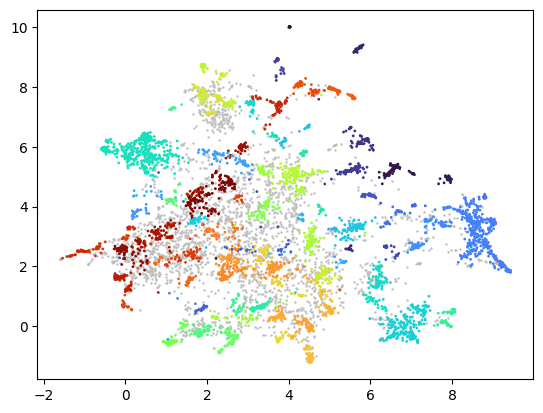

In [111]:
fig, ax = plt.subplots()
ax.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.5)
ax.scatter(clustered.x, clustered.y, c=clustered.labels, s=1, cmap='turbo')
plt.show()

## Topic Extraction

In [95]:
import pandas as pd
df = dataset_processed.remove_columns(['embedding']).to_pandas()

docs_df = pd.DataFrame(df, columns=['text'])
docs_df['topic'] = cluster.labels_
docs_df = docs_df[docs_df.topic != -1]
docs_per_topic = docs_df.groupby(['topic'], as_index=False).agg({'text': ' '.join})

In [96]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 2)):
  count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
  t = count.transform(documents).astype(np.uint8).toarray()
  w = t.sum(axis=1)
  tf = np.divide(t.T, w)
  sum_t = t.sum(axis=0)
  idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
  tf_idf = np.multiply(tf, idf)

  return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.text.values, m=len(dataset_processed))

In [97]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
  words = count.get_feature_names_out()
  labels = list(docs_per_topic.topic)
  tf_idf_transposed = tf_idf.T
  indices = tf_idf_transposed.argsort()[:, -n:]
  top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
  return top_n_words

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic)

In [98]:
for topic in range(len(top_n_words)):
  print(', '.join([word[0] for word in top_n_words[topic][:10]]))

turkey, gobbler, pail, unk unk, unk, sue, red dress, red, dress, did
goat, nicknack, cow, horns, did, ted, way, loose, goat did, martin
christmas, santa claus, santa, claus, merry christmas, merry, tree, presents, christmas tree, dorothy
squirrels, squirrel, gray, red, gray squirrel, bobby gray, bobby, red squirrel, unk red, red squirrels
shoot, gun, popgun, margy doll, bun, mun bun, mun, margy, doll, boy
bear, rat, bears, fox, teddy, ted, jan, teddy bear, janet, maybe
dog, splash, bunny, barking, sue, dog splash, bunny sue, ran, did, brown
bees, honey, ant, bee, flies, stung, little ant, flowers, round, away bees
balloon, balloon said, russ, balloons, laddie, bun, mun bun, mun, make balloon, basket
race, russ, race finished, ready race, win, laddie, finished, guess, faster, russ laddie
monkey, organ, wango, hand organ, hand, italian, candy, organ man, winkler, man
playroom, house, live, look, play house, play, home, oh, playroom thought, play houses
castle, blue, stones, playhouse, bl